# Training with UNet

In [1]:
import os
import math
import random

import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf

os.environ['CUDA_VISIBLE_DEVICES'] = '0'

In [2]:
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 6986335431371735506
 xla_global_id: -1,
 name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 2256220980
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 11194129218637984998
 physical_device_desc: "device: 0, name: NVIDIA GeForce GTX 1650, pci bus id: 0000:01:00.0, compute capability: 7.5"
 xla_global_id: 416903419]

In [3]:
import tensorflow.keras.losses as losses

def iou(y_true, y_pred):
    smooth = 0.
    
    # Flatten
    y_true = tf.reshape(y_true, [-1])
    y_pred = tf.reshape(y_pred, [-1])
    
    intersection = tf.reduce_sum(y_true * y_pred)
    union = tf.reduce_sum(y_true) + tf.reduce_sum(y_pred) - intersection
    
    score = intersection / (union + smooth)
    
    return score

def dice_coef(y_true, y_pred):
    smooth = 0.
    
    # Flatten
    y_true = tf.reshape(y_true, [-1])
    y_pred = tf.reshape(y_pred, [-1])
    
    intersection = tf.reduce_sum(y_true * y_pred)
    score = (2. * intersection) / (tf.reduce_sum(y_true) + tf.reduce_sum(y_pred) + smooth)
    
    return score

def dice_loss(y_true, y_pred):
    loss = 1 - dice_coef(y_true, y_pred)

    return loss

def bce_dice_loss(y_true, y_pred):
    loss = 1.*losses.binary_crossentropy(y_true, y_pred) + 1.*dice_loss(y_true, y_pred)

    return loss

In [13]:
from tensorflow import keras
import albumentations as A
import cv2

class Augmentation:
    def __init__(self, size, mode='train'):
        if mode == 'train':
            # Declare an augmentation pipeline
            self.transform = A.Compose([
                A.HorizontalFlip(p=0.5),
                A.ShiftScaleRotate(
                    p=0.5,
                    shift_limit=0.05,
                    scale_limit=0.05,
                    rotate_limit=15
                ),
                A.CoarseDropout(
                    p=0.5,
                    max_holes=8,
                    max_height=int(0.1 * size),
                    max_width=int(0.1 * size)
                ),
                A.RandomBrightnessContrast(p=0.2),  
            ])
    def __call__(self, **kwargs):
        if self.transform:
            augmented = self.transform(**kwargs)
            img = augmented['image']
            mask = augmented['mask']
            return img, mask
        
class DataGenerator(keras.utils.Sequence):
    def __init__(self, batch_size, csv_path, fold, image_size,
                 mode='train', shuffle=True):
        self.batch_size = batch_size
        self.image_size = image_size
        self.shuffle = shuffle
        self.fold = fold
        self.mode = mode
        
        self.df = pd.read_csv(csv_path)
        
        if self.mode == 'train':
            self.df = self.df[self.df['fold'] != self.fold]
        elif self.mode == 'val':
            self.df = self.df[self.df['fold'] == self.fold]
        
        invalid_filnames = [
            'Egyptian_Mau_14',
            'Egyptian_Mau_139',
            'Egyptian_Mau_145',
            'Egyptian_Mau_156',
            'Egyptian_Mau_167',
            'Egyptian_Mau_177',
            'Egyptian_Mau_186',
            'Egyptian_Mau_191',
            'Abyssinian_5',
            'Abyssinian_34',
            'chihuahua_121',
            'beagle_116'
        ]
        self.df = self.df[-self.df['file_name'].isin(invalid_filnames)]
        self.transform = Augmentation(image_size, mode)
        
        self.on_epoch_end()
        
    def __len__(self):
        return math.ceil(len(self.df) / self.batch_size)
    
    def __getitem__(self, idx):
        start = idx * self.batch_size
        final = (idx + 1) * self.batch_size
        data = self.df.iloc[start:final]
        
        batch_x, batch_y = self.get_data(data)
        
        return np.array(batch_x), np.array(batch_y)
        
    def get_data(self, data):
        batch_x = []
        batch_y = []
        
        for _, r in data.iterrows():
            file_name = r['file_name']
            
            image = cv2.imread(f'data/images/{file_name}.jpg') # f는 f-string 문자열 포매팅
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            image = cv2.resize(image, (self.image_size, self.image_size))
            
            mask = cv2.imread(f'data/annotations/trimaps/{file_name}.png',
                              cv2.IMREAD_GRAYSCALE)
            mask = cv2.resize(mask, (self.image_size, self.image_size))
            mask[mask != 1] = 0
            
            
            if self.mode == 'train':
#                 image = image.astype('uint8')
                image, mask = self.transform(image=image, mask=mask)
                
            image = image.astype('float32')
            image = image / 255.
            mask = mask.astype('float32')
#             label = int(r['id']) - 1
            
            batch_x.append(image)
            batch_y.append(mask)
        
        return batch_x, batch_y
        
    def on_epoch_end(self):
        if self.shuffle:
            self.df = self.df.sample(frac=1).reset_index(drop=True)
            
csv_path = 'data/kfolds.csv'
train_generator = DataGenerator(
    fold=1,
    mode='train',
    csv_path=csv_path,
    batch_size=8,
    image_size=128,
    shuffle=True
)
valid_generator = DataGenerator(
    fold=1,
    mode='val',
    csv_path=csv_path,
    batch_size=8,
    image_size=128,
    shuffle=True
)

In [14]:
# https://github.com/karolzak/keras-unet
from keras_unet.models import custom_unet

model = custom_unet(
    input_shape=(128, 128, 3),
    use_batch_norm=True,
    upsample_mode='deconv',
    dropout_type='spatial',
    use_attention=True,
    num_classes=1,
    filters=64,
    dropout=0.2,
    num_layers=4,
    output_activation='sigmoid')

model.compile(optimizer='adam', loss=bce_dice_loss, metrics=[iou])
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_62 (Conv2D)             (None, 128, 128, 64  1728        ['input_3[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization_36 (BatchN  (None, 128, 128, 64  256        ['conv2d_62[0][0]']              
 ormalization)                  )                                                           

 conv2d_transpose_8 (Conv2DTran  (None, 16, 16, 512)  2097664    ['batch_normalization_45[0][0]'] 
 spose)                                                                                           
                                                                                                  
 conv2d_72 (Conv2D)             (None, 16, 16, 512)  262656      ['batch_normalization_43[0][0]'] 
                                                                                                  
 conv2d_73 (Conv2D)             (None, 16, 16, 512)  262656      ['conv2d_transpose_8[0][0]']     
                                                                                                  
 add_8 (Add)                    (None, 16, 16, 512)  0           ['conv2d_72[0][0]',              
                                                                  'conv2d_73[0][0]']              
                                                                                                  
 activatio

 concatenate_10 (Concatenate)   (None, 64, 64, 256)  0           ['conv2d_transpose_10[0][0]',    
                                                                  'multiply_10[0][0]']            
                                                                                                  
 conv2d_85 (Conv2D)             (None, 64, 64, 128)  294912      ['concatenate_10[0][0]']         
                                                                                                  
 batch_normalization_50 (BatchN  (None, 64, 64, 128)  512        ['conv2d_85[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 conv2d_86 (Conv2D)             (None, 64, 64, 128)  147456      ['batch_normalization_50[0][0]'] 
                                                                                                  
 batch_nor

In [15]:
help(custom_unet)

Help on function custom_unet in module keras_unet.models.custom_unet:

custom_unet(input_shape, num_classes=1, activation='relu', use_batch_norm=True, upsample_mode='deconv', dropout=0.3, dropout_change_per_layer=0.0, dropout_type='spatial', use_dropout_on_upsampling=False, use_attention=False, filters=16, num_layers=4, output_activation='sigmoid')
    Customisable UNet architecture (Ronneberger et al. 2015 [1]).
    
    Arguments:
    input_shape: 3D Tensor of shape (x, y, num_channels)
    
    num_classes (int): Unique classes in the output mask. Should be set to 1 for binary segmentation
    
    activation (str): A keras.activations.Activation to use. ReLu by default.
    
    use_batch_norm (bool): Whether to use Batch Normalisation across the channel axis between convolutional layers
    
    upsample_mode (one of "deconv" or "simple"): Whether to use transposed convolutions or simple upsampling in the decoder part
    
    dropout (float between 0. and 1.): Amount of dropout a

In [16]:
history = model.fit(
    train_generator,
    validation_data=valid_generator,
    epochs=10,
    verbose=1,
)

Epoch 1/10
735/735 [==============================] - 255s 338ms/step - loss: 0.9076 - iou: 0.4041 - val_loss: 0.9191 - val_iou: 0.5571
Epoch 2/10
735/735 [==============================] - 251s 341ms/step - loss: 0.6923 - iou: 0.5161 - val_loss: 0.6057 - val_iou: 0.5284
Epoch 3/10
735/735 [==============================] - 264s 360ms/step - loss: 0.6075 - iou: 0.5666 - val_loss: 0.5250 - val_iou: 0.6470
Epoch 4/10
735/735 [==============================] - 265s 360ms/step - loss: 0.5452 - iou: 0.6044 - val_loss: 0.4792 - val_iou: 0.6905
Epoch 5/10
735/735 [==============================] - 265s 360ms/step - loss: 0.5085 - iou: 0.6274 - val_loss: 0.4210 - val_iou: 0.6915
Epoch 6/10
735/735 [==============================] - 246s 335ms/step - loss: 0.4801 - iou: 0.6461 - val_loss: 0.4232 - val_iou: 0.6854
Epoch 7/10
735/735 [==============================] - 243s 331ms/step - loss: 0.4591 - iou: 0.6605 - val_loss: 0.3993 - val_iou: 0.7165
Epoch 8/10
735/735 [============================

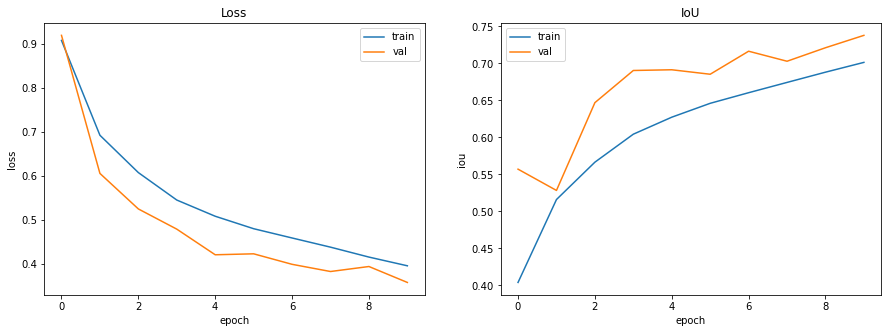

In [17]:
import matplotlib.pyplot as plt
history = history.history

plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.plot(history['loss'], label='train')
plt.plot(history['val_loss'], label='val')
plt.legend()
plt.xlabel('epoch')
plt.ylabel('loss')
plt.title("Loss")

plt.subplot(1, 2, 2)
plt.plot(history['iou'], label='train')
plt.plot(history['val_iou'], label='val')
plt.legend()
plt.xlabel('epoch')
plt.ylabel('iou')
plt.title("IoU")
plt.show()

In [18]:
for images, masks in valid_generator:
    break

In [19]:
preds = model.predict(images)

1/1 [==============================] - 0s 362ms/step


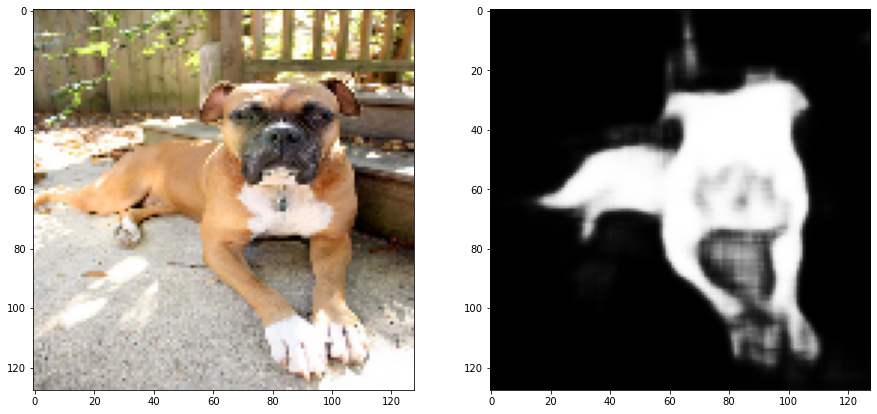

In [20]:
import random
idx = random.choice(range(len(preds)))
plt.figure(figsize=(15, 15))
plt.subplot(1, 2, 1)
plt.imshow(images[idx, ...])
plt.subplot(1, 2, 2)
plt.imshow(preds[idx, ..., 0], cmap='gray')